# Imports

In [1]:
import datetime
import glob
import itertools
import json
import os
import pickle
import random
import re
from string import punctuation

In [2]:
import statistics

import fuzzywuzzy
import geopandas as gpd
import humanize
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [3]:
# Instantiate a logistic regression classifier: logreg
clf_name = 'logreg'
logreg = LogisticRegression()
scalar = StandardScaler()
cv = KFold(n_splits=5)
pipeline = Pipeline(steps=[('transformer', scalar), (clf_name, logreg)])

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {f'{clf_name}__C': c_space}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(
    logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (average_precision_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, plot_precision_recall_curve,
                             precision_recall_curve, r2_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score,
                                     cross_validate, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import (make_pipeline, Pipeline)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale

In [4]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.ticker import PercentFormatter

px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Functions

In [5]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(
        alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2
    )
    ax.set_ylabel("CV Score +/- Std Error")
    ax.set_xlabel("Alpha")
    ax.axhline(np.max(cv_scores), linestyle="--", color=".5")
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale("log")
    plt.show()

# Voting Records

Origin: <https://archive-beta.ics.uci.edu/ml/datasets/Congressional%20Voting%20Records>

In [6]:
columns = [
    "party",
    "infants",
    "water",
    "budget",
    "physician",
    "salvador",
    "religious",
    "satellite",
    "aid",
    "missile",
    "immigration",
    "synfuels",
    "education",
    "superfund",
    "crime",
    "duty_free_exports",
    "eaa_rsa",
]
df = pd.read_csv("datasets/house-votes-84.csv", names=columns)

In [7]:
df

,party,infants,water,budget,physician,salvador,religious,satellite,aid,missile,immigration,synfuels,education,superfund,crime,duty_free_exports,eaa_rsa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,republican,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y
431,democrat,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y
432,republican,n,?,n,y,y,y,n,n,n,n,y,y,y,y,n,y
433,republican,n,n,n,y,y,y,?,?,?,?,n,y,y,y,n,y


In [8]:
# Convert '?' to NaN
df[df == "?"] = np.nan

# Print the number of NaNs
print(df.isnull().sum())

# Print shape of original DataFrame
print(f"Shape of Original DataFrame: {df.shape}")

# Drop missing values and print shape of new DataFrame
df = df.dropna()

# Print shape of new DataFrame
print(
    "Shape of DataFrame After Dropping All Rows with Missing Values: {}".format(
        df.shape
    )
)

party                  0
infants               12
water                 48
budget                11
physician             11
salvador              15
religious             11
satellite             14
aid                   15
missile               22
immigration            7
synfuels              21
education             31
superfund             25
crime                 17
duty_free_exports     28
eaa_rsa              104
dtype: int64
Shape of Original DataFrame: (435, 17)
Shape of DataFrame After Dropping All Rows with Missing Values: (232, 17)


In [9]:
df = df.replace("y", 1)
df = df.replace("n", 0)

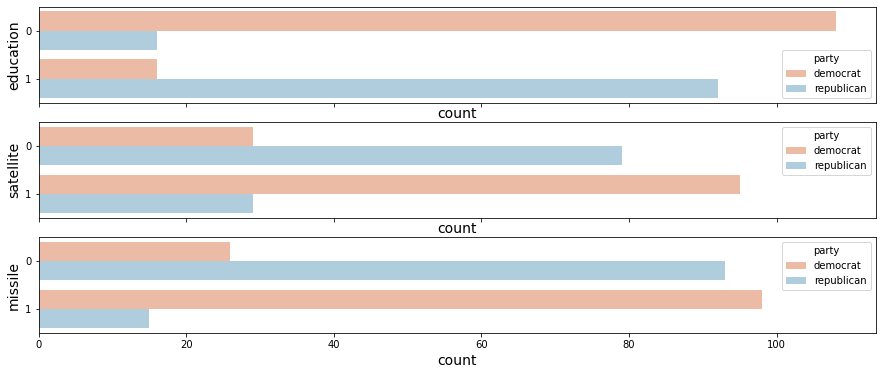

In [10]:
fig, ax = plt.subplots(3, 1, sharex=True)
bill_types = ["education", "satellite", "missile"]
for idx, bill in enumerate(bill_types):
    _ = sns.countplot(y=bill, hue="party", data=df, palette="RdBu", ax=ax[idx])

In [11]:
# Create arrays for the features and the response variable
y = df["party"].values
X = df.drop("party", axis=1).values

In [12]:
# Import necessary modules
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Setup the pipeline steps: steps
imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
steps = [("imputation", imputer), ("SVM", SVC())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps=steps)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit the pipeline to the train set
pipeline.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = pipeline.predict(X_test)

# Compute metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    democrat       0.97      0.97      0.97        36
  republican       0.97      0.97      0.97        34

    accuracy                           0.97        70
   macro avg       0.97      0.97      0.97        70
weighted avg       0.97      0.97      0.97        70



# Digits

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are di

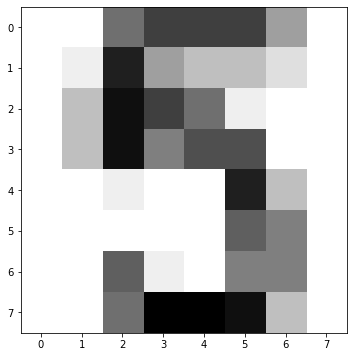

In [13]:
import matplotlib.pyplot as plt
# Import necessary modules
from sklearn import datasets

# Load the digits dataset: digits
digits = datasets.load_digits()

# Print the keys and DESCR of the dataset
print(digits.keys())
print(digits.DESCR)

# Print the shape of the images and data keys
print(digits.images.shape)
print(digits.data.shape)

# Display digit 1010
plt.imshow(digits.images[1010], cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier

# Create feature and target arrays
X = digits.data
y = digits.target

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create a k-NN classifier with 7 neighbors: knn
knn = KNeighborsClassifier(n_neighbors=7)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Print the accuracy
print(knn.score(X_test, y_test))

0.9833333333333333


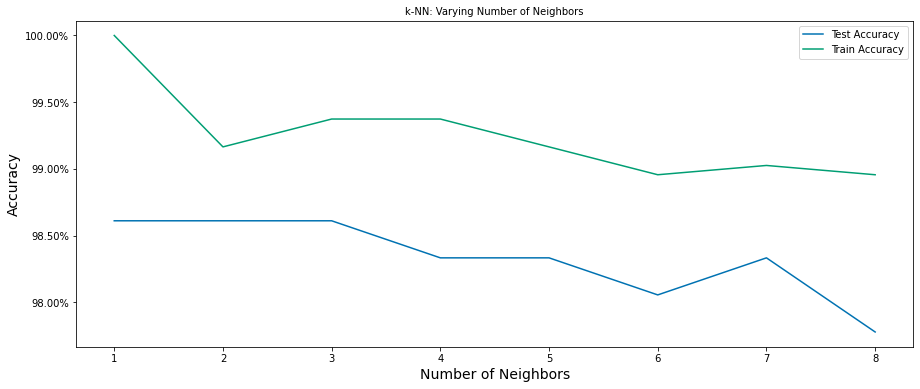

In [15]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)

    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
fig, ax = plt.subplots()
plt.title("k-NN: Varying Number of Neighbors")
plt.plot(neighbors, test_accuracy, label="Test Accuracy")
plt.plot(neighbors, train_accuracy, label="Train Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

# Gapminder

## Data

In [16]:
# Read the CSV file into a DataFrame: df
df = pd.read_csv("datasets/gapminder.csv")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   population       139 non-null    float64
 1   fertility        139 non-null    float64
 2   HIV              139 non-null    float64
 3   CO2              139 non-null    float64
 4   BMI_male         139 non-null    float64
 5   GDP              139 non-null    float64
 6   BMI_female       139 non-null    float64
 7   life             139 non-null    float64
 8   child_mortality  139 non-null    float64
 9   Region           139 non-null    object 
dtypes: float64(9), object(1)
memory usage: 11.0+ KB


In [18]:
df.describe()

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality
count,1.390000e+02,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,3.549977e+07,3.005108,1.915612,4.459874,24.623054,16638.784173,126.701914,69.602878,45.097122
std,1.095121e+08,1.615354,4.408974,6.268349,2.209368,19207.299083,4.471997,9.122189,45.724667
min,2.773150e+05,1.280000,0.060000,0.008618,20.397420,588.000000,117.375500,45.200000,2.700000
25%,3.752776e+06,1.810000,0.100000,0.496190,22.448135,2899.000000,123.232200,62.200000,8.100000
50%,9.705130e+06,2.410000,0.400000,2.223796,25.156990,9938.000000,126.519600,72.000000,24.000000
75%,2.791973e+07,4.095000,1.300000,6.589156,26.497575,23278.500000,130.275900,76.850000,74.200000
max,1.197070e+09,7.590000,25.900000,48.702062,28.456980,126076.000000,135.492000,82.600000,192.000000


In [19]:
df.sample(10)

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality,Region
32,11290239.0,1.50,0.10,2.701777,25.06867,17765.0,126.0594,77.8,6.3,America
115,50348811.0,2.54,17.90,9.427960,26.85538,12263.0,130.9949,55.0,66.1,Sub-Saharan Africa
12,306165.0,2.91,2.40,1.360126,27.02255,8293.0,120.9224,70.7,20.1,America
101,90297115.0,3.26,0.06,0.842121,22.87263,5332.0,122.3459,69.4,33.4,East Asia & Pacific
123,7254072.0,3.70,0.20,0.453168,23.77966,2001.0,129.9657,69.5,56.2,Europe & Central Asia
41,843206.0,2.74,0.10,1.277780,26.53078,7129.0,127.4768,65.7,24.0,East Asia & Pacific
91,5594524.0,2.72,0.20,0.778152,25.77291,4060.0,123.4792,75.2,28.1,America
96,163096985.0,3.58,0.10,0.935618,22.29914,4187.0,126.5196,64.1,95.5,South Asia
64,2717344.0,2.39,1.70,4.391456,24.00421,8951.0,125.3685,75.5,18.9,America
94,4771633.0,1.96,0.10,10.529769,26.93424,65216.0,126.0266,80.7,3.6,Europe & Central Asia


<AxesSubplot:>

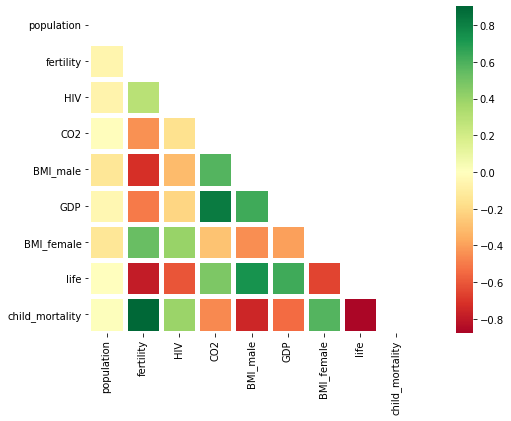

In [20]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="RdYlGn", center=0, square=True, linewidths=5)

<AxesSubplot:xlabel='Region', ylabel='life'>

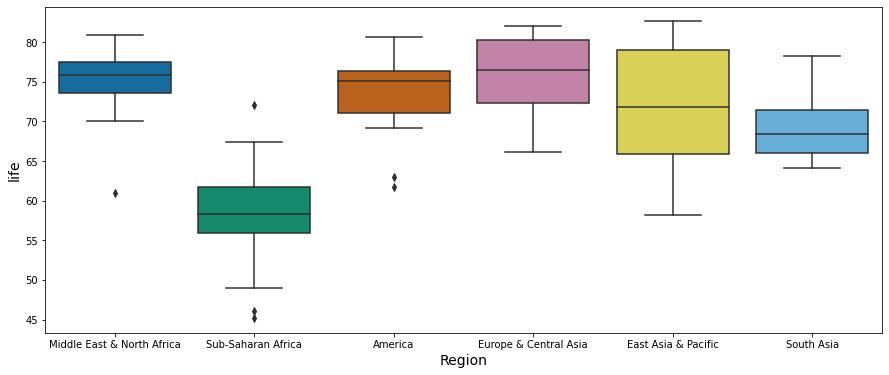

In [21]:
sns.boxplot(data=df, x="Region", y="life")

In [22]:
# Create dummy variables: df_region
df_region = pd.get_dummies(df)

# Print the columns of df_region
print(df_region.columns)

# Create dummy variables with drop_first=True: df_region
df_region = pd.get_dummies(df, drop_first=True)

# Print the new columns of df_region
print(df_region.columns)

Index(['population', 'fertility', 'HIV', 'CO2', 'BMI_male', 'GDP',
       'BMI_female', 'life', 'child_mortality', 'Region_America',
       'Region_East Asia & Pacific', 'Region_Europe & Central Asia',
       'Region_Middle East & North Africa', 'Region_South Asia',
       'Region_Sub-Saharan Africa'],
      dtype='object')
Index(['population', 'fertility', 'HIV', 'CO2', 'BMI_male', 'GDP',
       'BMI_female', 'life', 'child_mortality', 'Region_East Asia & Pacific',
       'Region_Europe & Central Asia', 'Region_Middle East & North Africa',
       'Region_South Asia', 'Region_Sub-Saharan Africa'],
      dtype='object')


## One Feature 

Dimensions of y before reshaping:  (139,)
Dimensions of X before reshaping:  (139,)
Dimensions of y after reshaping:  (139, 1)
Dimensions of X after reshaping:  (139, 1)
0.6192442167740035


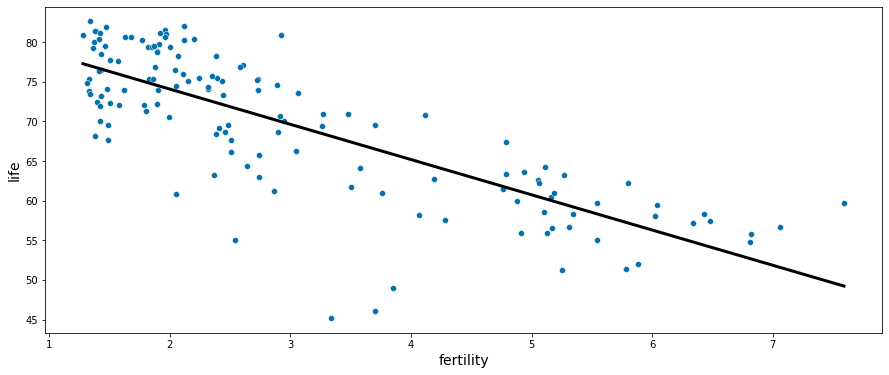

In [23]:
# Create arrays for features and target variable
y = df.life.to_numpy()
X = df.fertility.to_numpy()

# Print the dimensions of y and X before reshaping
print("Dimensions of y before reshaping: ", y.shape)
print("Dimensions of X before reshaping: ", X.shape)

# Reshape X and y
y_reshaped = y.reshape(-1, 1)
X_reshaped = X.reshape(-1, 1)

# Print the dimensions of y_reshaped and X_reshaped
print("Dimensions of y after reshaping: ", y_reshaped.shape)
print("Dimensions of X after reshaping: ", X_reshaped.shape)

# Import LinearRegression
from sklearn.linear_model import LinearRegression

# Create the regressor: reg
reg = LinearRegression()

# Create the prediction space
prediction_space = np.linspace(min(X_reshaped), max(X_reshaped)).reshape(-1, 1)

# Fit the model to the data
reg.fit(X_reshaped, y)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(prediction_space)

# Print R^2
print(reg.score(X_reshaped, y))

# Plot regression line
sns.scatterplot(data=df, x="fertility", y="life")
plt.plot(prediction_space, y_pred, color="black", linewidth=3)

## Many Features

In [24]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# data
target = "life"
drop_cols = "Region"
y = df[target]
X = df.drop([target, drop_cols], axis=1)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print(f"R^2: {reg_all.score(X_test, y_test)}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

R^2: 0.8380468731429358
Root Mean Squared Error: 3.247601080037724


## Add k-fold CV

In [25]:
# Import the necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X, y, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)
print(f"Average 5-Fold CV Score: {np.mean(cv_scores)}")

[0.81720569 0.82917058 0.90214134 0.80633989 0.94495637]
Average 5-Fold CV Score: 0.8599627722793233


## Add Regularization

Residual sum of squares (RSS):

- L2 Ridge -- $RSS_\text{ridge} = \sum_{i=1}^n [y_i - (w * x_i + b)]^2 + \lambda * \sum_{j=1}^p w_j^2$
- L1 Lasso -- $RSS_\text{lasso} = \sum_{i=1}^n [y_i - (w * x_i + b)]^2 + \lambda * \sum_{j=1}^p |w_j|$

[-0.         -0.         -0.          0.          0.          0.
 -0.         -0.07087587]


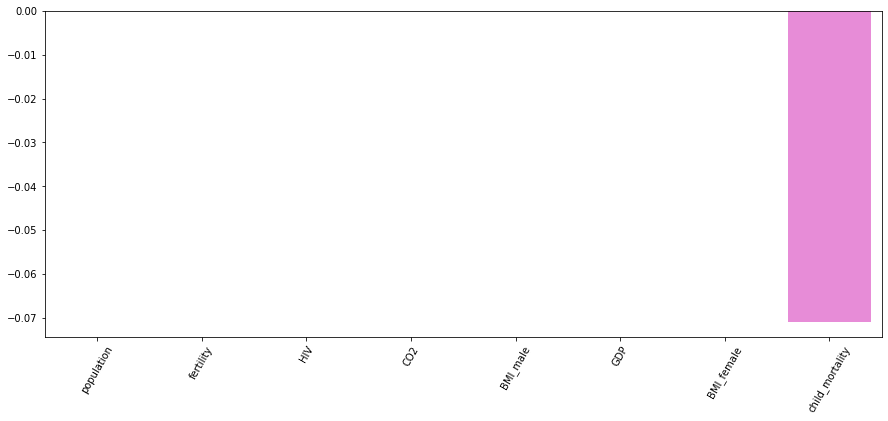

In [26]:
# Import Lasso
from sklearn.linear_model import Lasso

# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.4, normalize=True)

# Fit the regressor to the data
lasso.fit(X, y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

# Plot the coefficients
dummy_x = [x for x in range(len(X.columns))]
sns.barplot(x=dummy_x, y=lasso_coef)
plt.xticks(dummy_x, X.columns.values, rotation=60);

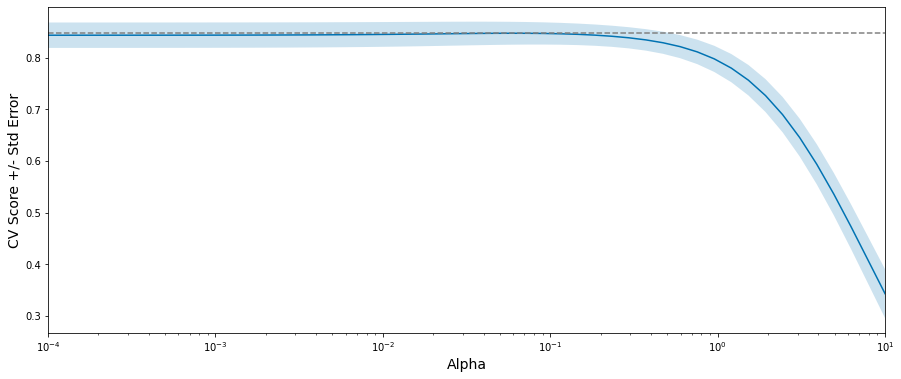

In [27]:
# Import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 1, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha

    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)

    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))

    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

## True Holdout

In [28]:
# Import necessary modules
from sklearn.linear_model import ElasticNet

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Instantiate a logistic regression classifier: logreg
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
scaler = StandardScaler()
clf_name = "elastic_net"
elastic_net = ElasticNet()
cv = KFold(n_splits=5)
steps = [
    ("imputation", imputer),
    ("scaler", StandardScaler()),
    (clf_name, ElasticNet()),
]
pipeline = Pipeline(steps)

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
parameters = {f"{clf_name}__l1_ratio": l1_space}

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=-1)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Tuned ElasticNet Alpha: {gm_cv.best_params_}")
print(f"Tuned ElasticNet R squared: {r2}")
print(f"Tuned ElasticNet MSE: {mse}")

Tuned ElasticNet Alpha: {'elastic_net__l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.8862016570888216
Tuned ElasticNet MSE: 8.594868056487128


# Pima Indians

## Data

In [29]:
df = pd.read_csv("datasets/diabetes.csv")

In [30]:
df.sample(10)

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
350,4,92,80,0,0,42.2,0.237,29,0
172,2,87,0,23,0,28.9,0.773,25,0
29,5,117,92,0,0,34.1,0.337,38,0
412,1,143,84,23,310,42.4,1.076,22,0
723,5,117,86,30,105,39.1,0.251,42,0
552,6,114,88,0,0,27.8,0.247,66,0
125,1,88,30,42,99,55.0,0.496,26,1
339,7,178,84,0,0,39.9,0.331,41,1
629,4,94,65,22,0,24.7,0.148,21,0
73,4,129,86,20,270,35.1,0.231,23,0


In [31]:
target = "diabetes"
y = df[target]
X = df.drop(target, axis=1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## KNN

Precision: $\frac{t_p}{t_p + f_p}$

High precision has a low false positive rate, for example, not many real emails are classified as spam.


Recall, aka Sensitivity: $\frac{t_p}{t_p + f_n}$

High recall has a low false negative rate, for example, most spam emails are labeled as spam.

In [34]:
# Instantiate a k-NN classifier: knn
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the training data
knn.fit(X_train_scaled, y_train)

# Predict the labels of the test data: y_pred
y_pred = knn.predict(X_test_scaled)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[176  30]
 [ 57  45]]
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       206
           1       0.60      0.44      0.51       102

    accuracy                           0.72       308
   macro avg       0.68      0.65      0.66       308
weighted avg       0.70      0.72      0.70       308



## Logistic Regression

In [35]:
# Create the classifier: logreg
logreg = LogisticRegression(random_state=42)

# Fit the classifier to the training data
logreg.fit(X_train_scaled, y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test_scaled)
y_score = logreg.decision_function(X_test_scaled)
average_precision = average_precision_score(y_test, y_score)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"Average precision-recall score: {average_precision:0.2f}")

[[168  38]
 [ 36  66]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       206
           1       0.63      0.65      0.64       102

    accuracy                           0.76       308
   macro avg       0.73      0.73      0.73       308
weighted avg       0.76      0.76      0.76       308

Average precision-recall score: 0.68


## ROC

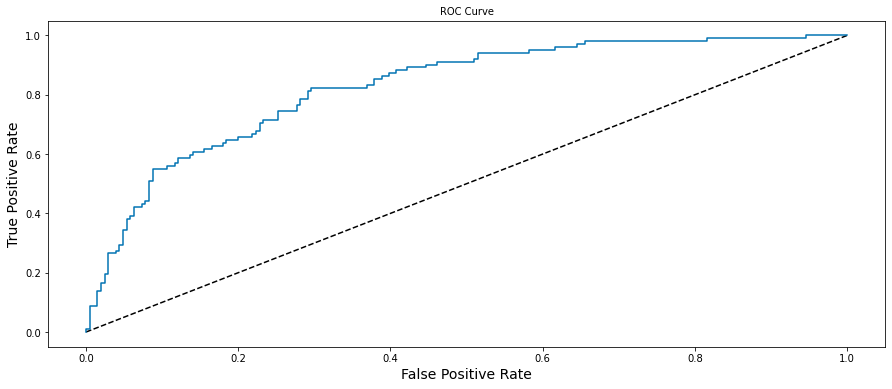

In [36]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test_scaled)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.68')

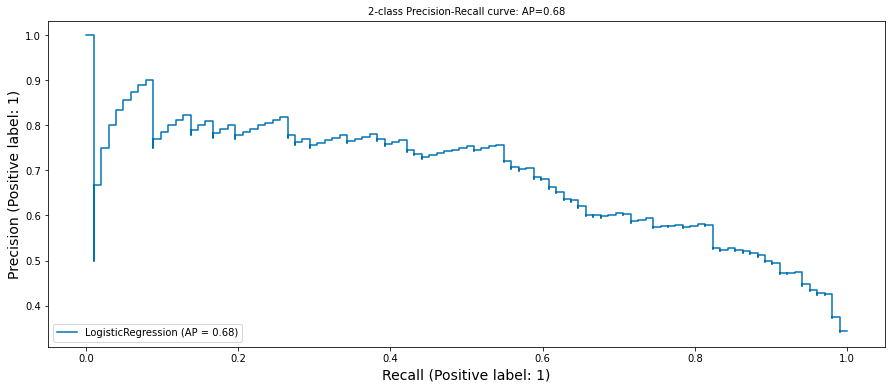

In [37]:
disp = plot_precision_recall_curve(logreg, X_test_scaled, y_test)
disp.ax_.set_title(
    "2-class Precision-Recall curve: " "AP={:0.2f}".format(average_precision)
)

## AUC

In [38]:
# Compute and print AUC score
print(f"AUC: {roc_auc_score(y_test, y_pred_prob)}")

# Compute cross-validated AUC scores: cv_auc
scalar = StandardScaler()
pipeline = Pipeline([("transformer", scalar), ("estimator", logreg)])
cv = KFold(n_splits=5)
cv_auc = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc")

# Print list of AUC scores
print(f"AUC scores computed using 5-fold cross-validation: {cv_auc}")

AUC: 0.8251475347420522
AUC scores computed using 5-fold cross-validation: [0.81240741 0.80555556 0.82637005 0.87336932 0.84586607]


## Grid Search CV

In [39]:
# Instantiate a logistic regression classifier: logreg
clf_name = "logreg"
logreg = LogisticRegression()
scalar = StandardScaler()
cv = KFold(n_splits=5)
pipeline = Pipeline(steps=[("transformer", scalar), (clf_name, logreg)])

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {f"{clf_name}__C": c_space}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(X, y)

# Print the tuned parameters and score
print(f"Tuned Logistic Regression Parameters: {logreg_cv.best_params_}")
print(f"Best score is {logreg_cv.best_score_}")

Tuned Logistic Regression Parameters: {'logreg__C': 0.4393970560760795}
Best score is 0.7722094898565487


## Randomized Search CV

In [40]:
# Import necessary modules
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# Instantiate a logistic regression classifier: logreg
clf_name = "tree"
tree = DecisionTreeClassifier()
scalar = StandardScaler()
cv = KFold(n_splits=5)
pipeline = Pipeline(steps=[("transformer", scalar), (clf_name, tree)])

# Setup the parameters and distributions to sample from: param_dist
param_dist = {
    f"{clf_name}__max_depth": [3, None],
    f"{clf_name}__max_features": randint(1, 9),
    f"{clf_name}__min_samples_leaf": randint(1, 9),
    f"{clf_name}__criterion": ["gini", "entropy"],
}


# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(pipeline, param_dist, cv=cv, n_jobs=-1)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters:")
for k, v in tree_cv.best_params_.items():
    print(f"   {k} --> {v}")
print(f"Best score is {tree_cv.best_score_}")

Tuned Decision Tree Parameters:
   tree__criterion --> entropy
   tree__max_depth --> 3
   tree__max_features --> 5
   tree__min_samples_leaf --> 4
Best score is 0.7448688566335624


# Wine

## Data

In [41]:
df = pd.read_csv("datasets/white-wine.csv", sep=",")

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [43]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [44]:
df.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2133,8.3,0.24,0.27,2.10,0.030,22.0,162.0,0.99140,2.99,0.68,11.9,6
2298,6.3,0.41,0.18,3.50,0.027,23.0,109.0,0.99018,3.34,0.54,12.8,8
4209,6.6,0.23,0.32,1.70,0.024,26.0,102.0,0.99084,3.29,0.60,11.8,6
1000,8.0,0.19,0.36,1.80,0.050,16.0,84.0,0.99360,3.15,0.45,9.8,7
4806,6.6,0.28,0.09,10.90,0.051,37.0,131.0,0.99566,2.93,0.62,9.5,6
4477,6.4,0.32,0.26,7.90,0.050,53.0,180.0,0.99514,3.14,0.50,9.6,5
3074,6.6,0.25,0.33,8.50,0.042,29.0,141.0,0.99546,3.28,0.60,10.4,5
4430,8.1,0.36,0.59,13.60,0.051,60.0,134.0,0.99886,2.96,0.39,8.7,5
4396,7.4,0.27,0.26,11.80,0.053,55.0,173.0,0.99699,3.11,0.60,9.8,5
4748,6.1,0.34,0.24,18.35,0.050,33.0,184.0,0.99943,3.12,0.61,9.3,5


<AxesSubplot:>

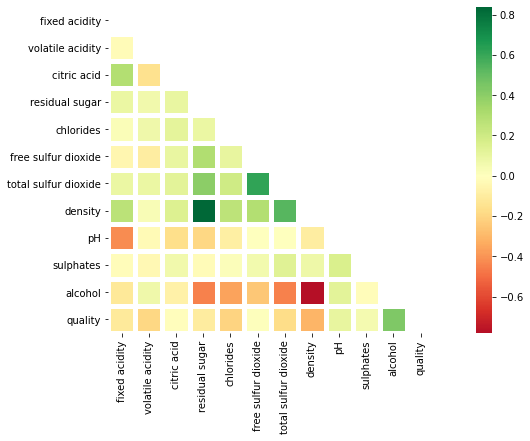

In [45]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="RdYlGn", center=0, square=True, linewidths=5)

In [46]:
target = "quality"
y = df[target]
X = df.drop(target, axis=1)

## KNN

In [47]:
# Setup the pipeline steps: steps
steps = [("scaler", StandardScaler()), ("knn", KNeighborsClassifier())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit the pipeline to the training set: knn_scaled
knn_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
knn_unscaled = KNeighborsClassifier().fit(X_train, y_train)

# Compute and print metrics
print(f"Accuracy with Scaling: {knn_scaled.score(X_test, y_test)}")
print(f"Accuracy without Scaling: {knn_unscaled.score(X_test, y_test)}")

Accuracy with Scaling: 0.5496598639455782
Accuracy without Scaling: 0.47551020408163264


## SVM

In [48]:
# Setup the pipeline
steps = [("scaler", StandardScaler()), ("SVM", SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {"SVM__C": [1, 10, 100], "SVM__gamma": [0.1, 0.01]}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21
)

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print(f"Accuracy: {cv.score(X_test, y_test)}")
print(classification_report(y_test, y_pred))
print(f"Tuned Model Parameters: {cv.best_params_}")

Accuracy: 0.6081632653061224
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.24      0.39      0.30        28
           5       0.61      0.62      0.61       289
           6       0.66      0.66      0.66       447
           7       0.62      0.54      0.58       177
           8       0.47      0.42      0.44        38

    accuracy                           0.61       980
   macro avg       0.43      0.44      0.43       980
weighted avg       0.61      0.61      0.61       980

Tuned Model Parameters: {'SVM__C': 100, 'SVM__gamma': 0.1}
